In [1]:
from efootball.src.classes.models.HomographyProjection import HomographyProjection

Segmentation Models: using `keras` framework.


In [2]:
model = HomographyProjection(backbone="efficientnetb3", num_classes=29, input_shape=(320,320))

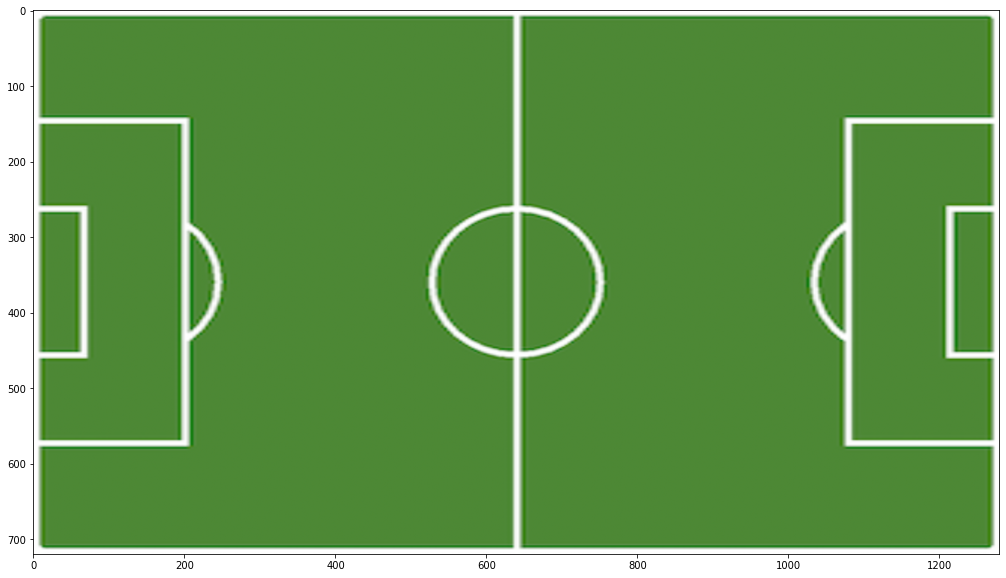

In [3]:
model.visualize_template()

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np

from efootball.src.classes.models.narya_field_homography.KeypointDetectorModel import KeypointDetectorModel
from efootball.src.classes.models.detectron2_person.ModelPerson import PersonDetector 
from efootball.src.classes.models.narya_field_homography.utils.image import denormalize
from efootball.src.classes.models.narya_field_homography.utils.visualization import visualize, rgb_template_to_coord_conv_template, merge_template
from efootball.src.classes.models.narya_field_homography.utils.masks import points_from_mask
from efootball.src.classes.models.narya_field_homography.utils.homography import get_perspective_transform, warp_image
from efootball.src.constants.models import NARYA_KEYPOINT_DETECTOR, NARYA_WEIGTHS_NAME, NARYA_WEIGHTS_TOTAR

from efootball.src.utils.players import define_player_centroid
from efootball.src.utils.geometry import define_center_point

In [15]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from efootball.src.classes.models.PersonDetector import PersonDetector
from efootball.src.classes.models.narya_field_homography.KeypointDetectorModel import KeypointDetectorModel
from efootball.src.utils.geometry import define_center_point
from efootball.src.classes.models.narya_field_homography.utils.image import denormalize
from efootball.src.classes.models.narya_field_homography.utils.visualization import visualize, rgb_template_to_coord_conv_template, merge_template
from efootball.src.classes.models.narya_field_homography.utils.masks import points_from_mask
from efootball.src.classes.models.narya_field_homography.utils.homography import get_perspective_transform, warp_image

from efootball.src.constants.models import NARYA_KEYPOINT_DETECTOR, NARYA_WEIGTHS_NAME, NARYA_WEIGHTS_TOTAR

In [2]:
person_detector = PersonDetector(0.6)

In [3]:
field_image = cv2.imread('C:/Users/ferna/OneDrive/Documentos/Insper/Efootball/data/frames/90.png')
field_image = cv2.cvtColor(field_image, cv2.COLOR_BGR2RGB)
image_with_persons = field_image.copy()
field_image = cv2.resize(field_image, (320, 320))
points_field_image = field_image.copy()

In [4]:
persons_locations = person_detector.detect_persons(image_with_persons)

c:\Users\ferna\anaconda3\envs\efootball\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
tx = image_with_persons.shape[0]/320
ty = image_with_persons.shape[1]/320
persons_points = list()
i = 0
for box, label in zip(persons_locations["boxes"], persons_locations['labels']):
    if label == 0:
        player_center_point = define_center_point(box)
        point = np.array([player_center_point[0]/ty, player_center_point[1]/tx])
        persons_points.append(point)
        cv2.putText(points_field_image, str(i), (int(point[0]), int(point[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,0,0), 1)
        i += 1

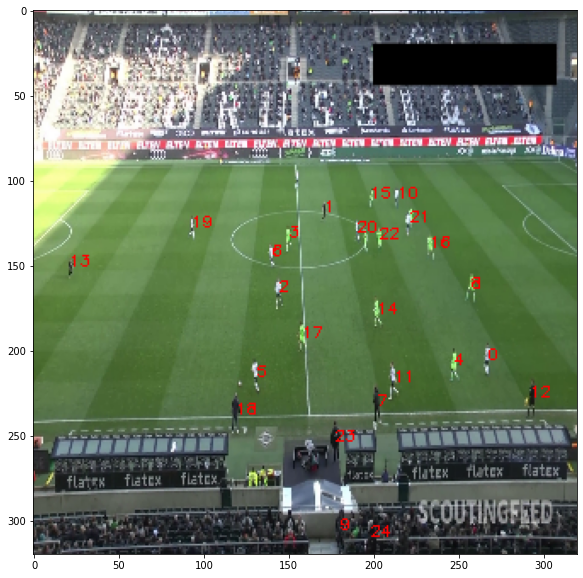

In [7]:
plt.figure(figsize=(20, 10))
plt.imshow(points_field_image)
plt.show()

In [13]:
kp_model = KeypointDetectorModel(backbone='efficientnetb3', num_classes=29, input_shape=(320, 320))
checkpoints = tf.keras.utils.get_file(NARYA_WEIGTHS_NAME, NARYA_KEYPOINT_DETECTOR, NARYA_WEIGHTS_TOTAR)
kp_model.load_weights(checkpoints)
pr_mask = kp_model(field_image)

Succesfully loaded weights from C:\Users\ferna\.keras\datasets\keypoint_detector.h5


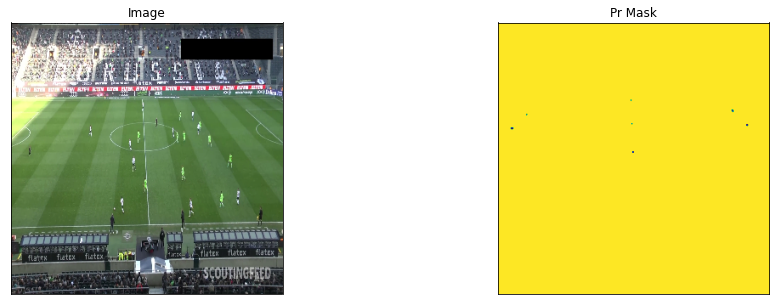

In [16]:
visualize(image=denormalize(field_image.squeeze()),pr_mask=pr_mask[..., -1].squeeze())

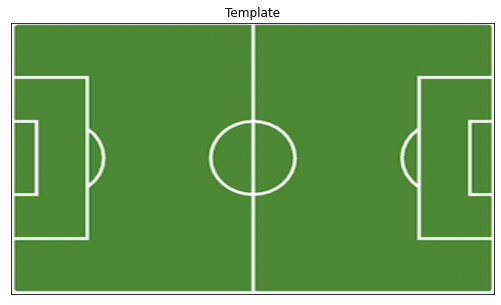

In [17]:
template = cv2.imread('C:/Users/ferna/OneDrive/Documentos/Insper/Efootball/efootball/src/img/football_field.png')
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
template = cv2.resize(template, (1280,720))/255.
visualize(template=template)

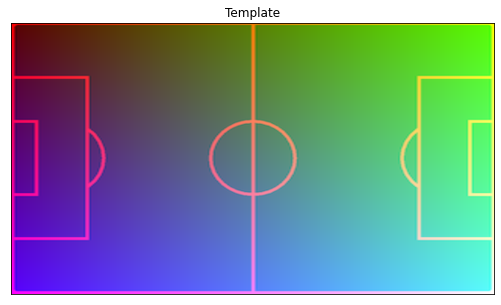

In [18]:
template = rgb_template_to_coord_conv_template(template)
visualize(template=template)

In [19]:
src,dst = points_from_mask(pr_mask[0])
pred_homo = get_perspective_transform(dst,src)
pred_warp = warp_image(cv2.resize(template, (320,320)),pred_homo,out_shape=(320,320))

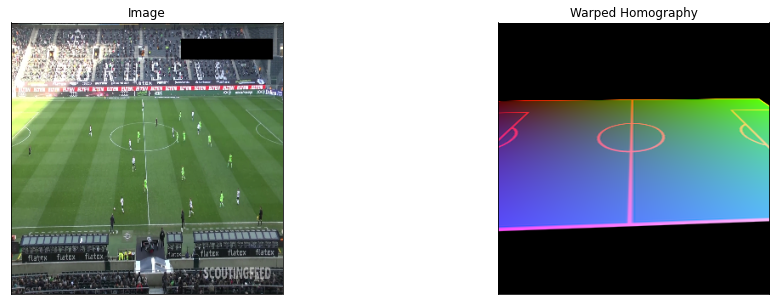

In [20]:
visualize(
        image=denormalize(field_image.squeeze()),
        warped_homography=pred_warp,
    )

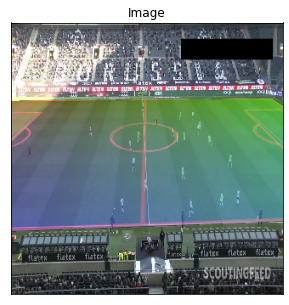

In [21]:
test = merge_template(field_image/255.,cv2.resize(pred_warp, (320, 320)))
visualize(image = test)

In [22]:
inverted_pred_homo = np.linalg.inv(pred_homo)
person_points_test = np.array(persons_points)
person_points_test = person_points_test.astype(np.float32)
pt_transformed = cv2.perspectiveTransform(person_points_test.reshape(-1, 1, 2), inverted_pred_homo)
perspective_transformed = pt_transformed.reshape(-1, 2)

In [23]:
resize_template = cv2.resize(template, (320, 320))

In [24]:
#draw points on template with a number
resize_template2 = resize_template.copy()
for i, point in enumerate(perspective_transformed):
    cv2.putText(resize_template2, str(i), (int(point[0]), int(point[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,0,0), 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


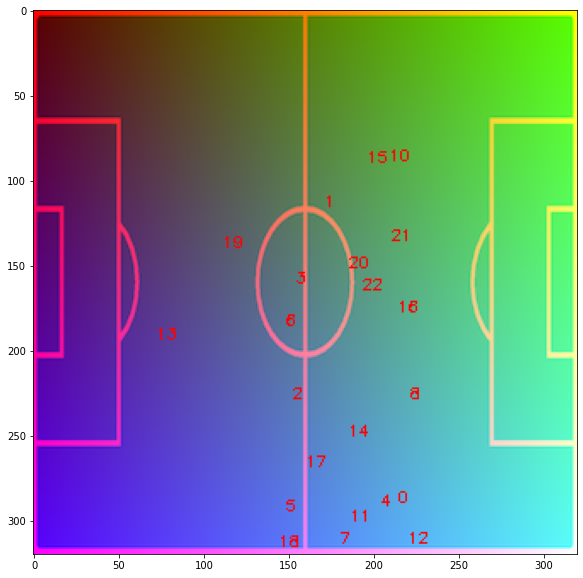

In [25]:
plt.figure(figsize=(20, 10))
plt.imshow(resize_template2)
plt.show()

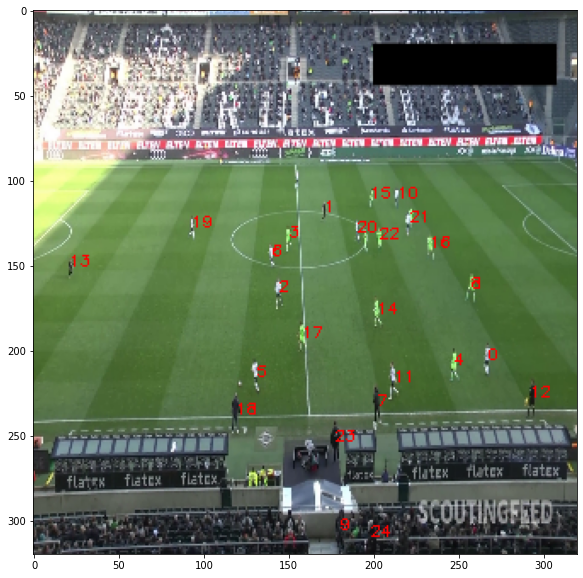

In [26]:
plt.figure(figsize=(20, 10))
plt.imshow(points_field_image)
plt.show()